In [1]:
# ЧЕРНОВОЙ ВАРИАНТ выборочно корректирует веса нейро экзаменатором
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
with open("config.txt", "w") as fw:
    fw.write("[COLAB]\n")
    fw.write("knowledge_dir=/content/drive/MyDrive/KIA_AVATAR/Scripts/knowledge\n")
    fw.write("prev_knowledge_dir=/content/drive/MyDrive/KIA_AVATAR/Scripts/../knowledge\n")
    fw.write("\n")
    fw.write("[PROM]\n")
    fw.write("knowledge_dir=/opt/knowledge\n")
    fw.write("prev_knowledge_dir=/knowledge\n")
    fw.write("\n")
    fw.write("[CHATGPT]\n")
    fw.write("api_key=?\n")
    fw.write("tokens_limit=0\n")
    fw.write("\n")
    fw.write("[GOOGLE]\n")
    fw.write("search_api_key=?\n")
    fw.write("search_limit=0\n")
    fw.write("\n")
    fw.write("[YANDEX]\n")
    fw.write("spellcheck_api_key=?\n")
    fw.write("spellcheck_limit=0\n")
    fw.write("\n")
    fw.write("[GITHUB]\n")
    fw.write("summary_api_key=?\n")
    fw.write("summary_limit=0\n")
    fw.write("\n")

msg = ""

In [3]:
!pip  install sentence-transformers==2.2.2 tiktoken==0.4.0  langchain==0.0.231 openai==0.27.8 faiss-cpu==1.7.4 qdrant_client==1.6.4

In [4]:
!rm -rf /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8
!mkdir -p /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8
!git clone -b test/ISSUE-8_retriever_trash https://github.com/musicnova/KIA-GPT0.git TEST_ISSUE_8
!cp -r /content/TEST_ISSUE_8/Yo_Basov/Embeddings/data /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8/data
!rm -r /content/TEST_ISSUE_8

Cloning into 'TEST_ISSUE_8'...
remote: Enumerating objects: 2348, done.
remote: Counting objects: 100% (764/764), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 2348 (delta 525), reused 638 (delta 451), pack-reused 1584
Receiving objects: 100% (2348/2348), 44.95 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (1366/1366), done.


In [5]:
        # закачаем векторные базы знаний в рабочий каталог из GitHub
        !git clone -b faiss/V30 https://github.com/musicnova/KIA-GPT0.git
        !cp -r /content/KIA-GPT0/knowledge/faiss_router /content/faiss_router
        !cp -r /content/KIA-GPT0/knowledge/faiss /content/faiss
        !rm -r /content/KIA-GPT0

Cloning into 'KIA-GPT0'...
remote: Enumerating objects: 2348, done.
remote: Counting objects: 100% (759/759), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 2348 (delta 513), reused 645 (delta 449), pack-reused 1589
Receiving objects: 100% (2348/2348), 45.47 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (1359/1359), done.


In [6]:
        # I. PART
        import configparser
        import pathlib
        import os
        config = configparser.ConfigParser()
        config.read('config.txt')
        knowledge_dir = config["COLAB"]["knowledge_dir"]
        if knowledge_dir is None: knowledge_dir = "./knowledge"
        pathlib.Path(knowledge_dir).mkdir(parents=True, exist_ok=True)
        prev_knowledge_dir = config["COLAB"]["prev_knowledge_dir"]
        if prev_knowledge_dir is None: prev_knowledge_dir = "../knowledge"
        pathlib.Path(prev_knowledge_dir).mkdir(parents=True, exist_ok=True)

        # !rm -rf /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8
        # !mkdir -p /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8
        # !git clone -b test/ISSUE-8_retriever_trash https://github.com/musicnova/KIA-GPT0.git TEST_ISSUE_8
        # !cp -r /content/TEST_ISSUE_8/Yo_Basov/Embeddings/data /content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8/data
        # !rm -r /content/TEST_ISSUE_8


        # закачаем векторные базы знаний в рабочий каталог из GitHub
        # !git clone -b faiss/V30 https://github.com/musicnova/KIA-GPT0.git
        # !cp -r /content/KIA-GPT0/knowledge/faiss_router /content/faiss_router
        # !cp -r /content/KIA-GPT0/knowledge/faiss /content/faiss
        # !rm -r /content/KIA-GPT0

        import os
        from pathlib import Path

        # Paths
        ROOT = Path("/content/drive/MyDrive/KIA_TEST/TEST_ISSUE_8/data").parent
        DATA = ROOT / "data"
        MAX_SENTENCE_LENGTH = 100

        # Qdrant
        QDRANT_HOST = "405ae107-6371-4f01-80b2-ac6973e1b00f.europe-west3-0.gcp.cloud.qdrant.io" # os.getenv("QDRANT_HOST")
        QDRANT_PORT = "6333" # os.getenv("QDRANT_PORT")
        QDRANT_API_KEY = "A75Z1wE_9O75sZVMEOi1wpg-FrE8yo6aZnbLje0jdFjquztdwCS65g" # os.getenv("QDRANT_API_KEY")
        COLLECTION_NAME = "meditations-collection"
        import sys

        import json
        import re
        from pathlib import Path

        from bs4 import BeautifulSoup
        def split_with_delimiter(text: str, delim: str) -> list:
            split_sentences = re.split(f"({delim})", text)
            combined_sentences: list = []
            for i in range(0, len(split_sentences)):
                if split_sentences[i] == ".":
                    combined_sentences[-1] += split_sentences[i]
                else:
                    combined_sentences.append(split_sentences[i])
                return combined_sentences

        def clean_text(text: str) -> str:
            clean_text = text.encode("ascii", "ignore").decode("utf-8")
            clean_text = re.sub(r" {2,}", " ", clean_text)
            clean_text = re.sub(r" \n", "\n", clean_text)
            clean_text = re.sub(r"\n ", "\n", clean_text).strip()
            return clean_text

        def extract_text_from_html(
            book: str,
            book_name: str,
            max_sentence_length: int = 100,
        ) -> None:
            file = DATA / "unzipped" / book / "index.html"
            output_folder = DATA / "processed" / book

            Path(output_folder).mkdir(parents=True, exist_ok=True)

            with open(file, "r") as f:
                soup = BeautifulSoup(f, "html.parser")

            data = []
            excluded_sections = ["GLOSSARY", "NOTES", "APPENDIX", "INTRODUCTION"]

            for section in soup.select("section"):
                if (
                    section.find("h2")
                    and section.find("h2").get_text().strip() not in excluded_sections
                ):
                    section_title = section.find("h2").get_text()
                    section_text = ""

                    for t in section.select("p"):
                        for elem_to_remove in (
                            t.select("[class='calibre24']")
                            + t.select("[class='mw-ref']")
                            + t.select("[class='reference']")
                        ):
                            elem_to_remove.decompose()
                        section_text += "\n" + t.get_text()

                    section_text = clean_text(section_text)

                    fixed_length_sentences = []

                    for paragraph in section_text.split("\n"):
                        if len(paragraph.split()) > max_sentence_length:
                            sentences = split_with_delimiter(paragraph, "\.")
                            current_sentence = ""

                            for i in range(len(sentences)):
                                if (
                                    len(current_sentence.split()) + len(sentences[i].split())
                                    < max_sentence_length
                                ):
                                    current_sentence += sentences[i]
                                else:
                                    fixed_length_sentences.append(current_sentence)
                                    current_sentence = sentences[i]
                        else:
                            fixed_length_sentences.append(paragraph)

                    data.append(
                        {
                            "title": section_title,
                            "url": f"https://en.wikisource.org/wiki/{book}#{'_'.join(section_title.split())}",
                            "sentences": fixed_length_sentences,
                        }
                    )

            output = {
                "book_title": book_name,
                "url": f"https://en.wikisource.org/wiki/{book}",
                "data": data,
            }

            json.dump(output, open(output_folder / f"{book}.json", "w"), indent=4)
            print(f"Saved {book}.json with content of book.")

            extract_text_from_html(
                "Marcus_Aurelius_Antoninus_-_His_Meditations_concerning_himselfe",
                "Meditations by Marcus Aurelius",
            )

            # II. PART
            import sys

            import json

            import numpy as np
            import pandas as pd
            import torch

            from qdrant_client import QdrantClient
            from qdrant_client.http import models
            from sentence_transformers import SentenceTransformer

            from tqdm.notebook import tqdm

            # FIXME from config import QDRANT_HOST, QDRANT_PORT, QDRANT_API_KEY, DATA, COLLECTION_NAME
            # Set relevant parameters
            BOOK_FILENAME = "Marcus_Aurelius_Antoninus_-_His_Meditations_concerning_himselfe"
            # Connect to Qdrant and create collection
            client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT, api_key=QDRANT_API_KEY)
            client.recreate_collection(
                collection_name=COLLECTION_NAME,
                vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE),
            )
            # Read sentences
            with open(f"{DATA}/processed/{BOOK_FILENAME}/{BOOK_FILENAME}.json", "r") as file:
                meditations_json = json.load(file)

            rows = []
            for chapter in tqdm(meditations_json["data"]):
                for sentence in chapter["sentences"]:
                    rows.append(
                        (
                            chapter["title"],
                            chapter["url"],
                            sentence,
                        )
                    )

            df = pd.DataFrame(data=rows, columns=["title", "url", "sentence"])

            df = df[df["sentence"].str.split().str.len() > 15]
            # Vectorize sentences
            model = SentenceTransformer(
                "msmarco-MiniLM-L-6-v3",
                device="cuda"
                if torch.cuda.is_available()
                else "mps"
                if torch.backends.mps.is_available()
                else "cpu",
            )

            vectors = []
            batch_size = 512
            batch = []

            for doc in tqdm(df["sentence"].to_list()):
                batch.append(doc)

                if len(batch) >= batch_size:
                    vectors.append(model.encode(batch))
                    batch = []

            if len(batch) > 0:
                vectors.append(model.encode(batch))
                batch = []

            vectors = np.concatenate(vectors)

            book_name = meditations_json["book_title"]

            client.upsert(
                collection_name=COLLECTION_NAME,
                points=models.Batch(
                    ids=[i for i in range(df.shape[0])],
                    payloads=[
                        {
                            "text": row["sentence"],
                            "title": row["title"] + f", {book_name}",
                            "url": row["url"],
                        }
                        for _, row in df.iterrows()
                    ],
                    vectors=[v.tolist() for v in vectors],
                ),
            )
        import getpass
        import openai
        import re

        if config["CHATGPT"]["api_key"] == "?":
            openai_key = getpass.getpass("OpenAI API Key:")
        else:
            openai_key = config["CHATGPT"]["api_key"]
        os.environ["OPENAI_API_KEY"] = openai_key
        openai.api_key = openai_key
        from qdrant_client import QdrantClient
        from sentence_transformers import SentenceTransformer

        qdrant_client = QdrantClient(
            host=QDRANT_HOST,
            port=QDRANT_PORT,
            api_key=QDRANT_API_KEY,
        )

        retrieval_model = SentenceTransformer("msmarco-MiniLM-L-6-v3")

        def build_prompt(question: str, references: list) -> tuple[str, str]:
            prompt = f"""
            You're Marcus Aurelius, emperor of Rome. You're giving advice to a friend who has asked you the following question: '{question}'

            You've selected the most relevant passages from your writings to use as source for your answer. Cite them in your answer.

            References:
            """.strip()

            references_text = ""

            for i, reference in enumerate(references, start=1):
                text = reference.payload["text"].strip()
                references_text += f"\n[{i}]: {text}"

            prompt += (
                references_text
                + "\nHow to cite a reference: This is a citation [1]. This one too [3]. And this is sentence with many citations [2][3].\nAnswer:"
            )
            return prompt, references_text

        def read_root():
            return {
                "message": "Make a post request to /ask to ask a question about Meditations by Marcus Aurelius"
            }

        def ask(question: str):
            similar_docs = qdrant_client.search(
                collection_name=COLLECTION_NAME,
                query_vector=retrieval_model.encode(question),
                limit=3,
                append_payload=True,
            )

            prompt, references = build_prompt(question, similar_docs)

            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "user", "content": prompt},
                ],
                max_tokens=250,
                temperature=0.2,
            )

            return {
                "response": response["choices"][0]["message"]["content"],
                "references": references,
            }

        # Визуальное представление векторных баз
        import pandas as pd
        from sklearn.manifold import TSNE
        import numpy as np
        from langchain.embeddings.openai import OpenAIEmbeddings
        from langchain.vectorstores import FAISS
        import getpass
        import os
        import openai
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt

        # Taking out the warnings
        import warnings
        from warnings import simplefilter

        # удалим папку parts, т.к. там всего один чанк и он вносит ошибку
        # !rm -r /content/faiss_router/faiss_parts

        vb_tech = FAISS.load_local('/content/faiss_router/faiss_technology', OpenAIEmbeddings())
        vb_acc = FAISS.load_local('/content/faiss_router/faiss_accessories', OpenAIEmbeddings())

        vb_path = '/content/faiss_router/'

        # Получить список имен папок в заданной папке
        vb_names = [name for name in os.listdir(vb_path) if os.path.isdir(os.path.join(vb_path, name))]

        print(vb_names)
        print(len(vb_names))

        # создадим список названий векторных баз по разделам
        list_names = [f'vb_{vb.split("_")[1]}' for vb in vb_names]

        print(list_names)
        print(len(list_names))

        # создадим список из векторных каждого раздела
        vb_list = [FAISS.load_local(f'/content/faiss_router/{vb}', OpenAIEmbeddings()) for vb in vb_names if vb not in ["faiss_parts"]]
        print(vb_list)

        # создадим список эмбеддингов для каждого чанка по разделам
        emb_list = [[list(vb.index.reconstruct_n(idx, 1)[0]) for idx in range(len(vb.docstore._dict))]for vb in vb_list]
        # преобразуем в список массивов по разделам
        np_list = [np.array([embeds for embeds in emb]) for emb in emb_list]

        print([arr.shape for arr in np_list])

        # Filter out FutureWarnings
        simplefilter(action='ignore', category=FutureWarning)

        # Выполним преобразование t-SNE в двух мерный массив
        tsne = TSNE(n_components=2, perplexity=6, random_state=42)
        np_tsne_list = [tsne.fit_transform(arr) for arr in np_list]

        print([np_tsne.shape for np_tsne in np_tsne_list])

        # построим график
        plt.figure(figsize=(16, 9))   # размер полотна в дюймах, (x, y)

        # Получаем количество элементов в np_tsne_list
        num_elements = len(np_tsne_list)

        # Генерируем цвета для каждого элемента
        colors = plt.cm.rainbow(np.linspace(0, 1, num_elements))

        # Создаем график scatter с указанием цветов для каждого элемента
        for i, np_tsne in enumerate(np_tsne_list):
            plt.scatter(np_tsne[:, 0], np_tsne[:, 1], label=list_names[i], c=[colors[i]])

        plt.xlabel('Dimension 1')     # названия осей
        plt.ylabel('Dimension 2')
        plt.title('KnowledgeBase Clustered')      # названия графика
        plt.legend()                                  # "легенды" - legend()
        # выведем график на экран
        plt.show()

        print(msg, " ... OK")

OpenAI API Key:··········
  ... OK


['faiss_technology', 'faiss_service', 'faiss_models', 'faiss_howto', 'faiss_accessories', 'faiss_info', 'faiss_sales', 'faiss_parts', 'faiss_promotions', 'faiss_oils', 'faiss_apps', 'faiss_warranty', 'faiss_tech']
13
['vb_technology', 'vb_service', 'vb_models', 'vb_howto', 'vb_accessories', 'vb_info', 'vb_sales', 'vb_parts', 'vb_promotions', 'vb_oils', 'vb_apps', 'vb_warranty', 'vb_tech']
13
[<langchain.vectorstores.faiss.FAISS object at 0x7ce0021c78e0>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c7a60>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c7e20>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c69e0>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c68c0>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c67d0>, <langchain.vectorstores.faiss.FAISS object at 0x7ce0021c6680>, <langchain.vectorstores.faiss.FAISS object at 0x7ce00b66ea70>, <langchain.vectorstores.faiss.FAISS object at 0x7ce00b5ef4f0>, <langchain.vectorstores.faiss.FAISS o

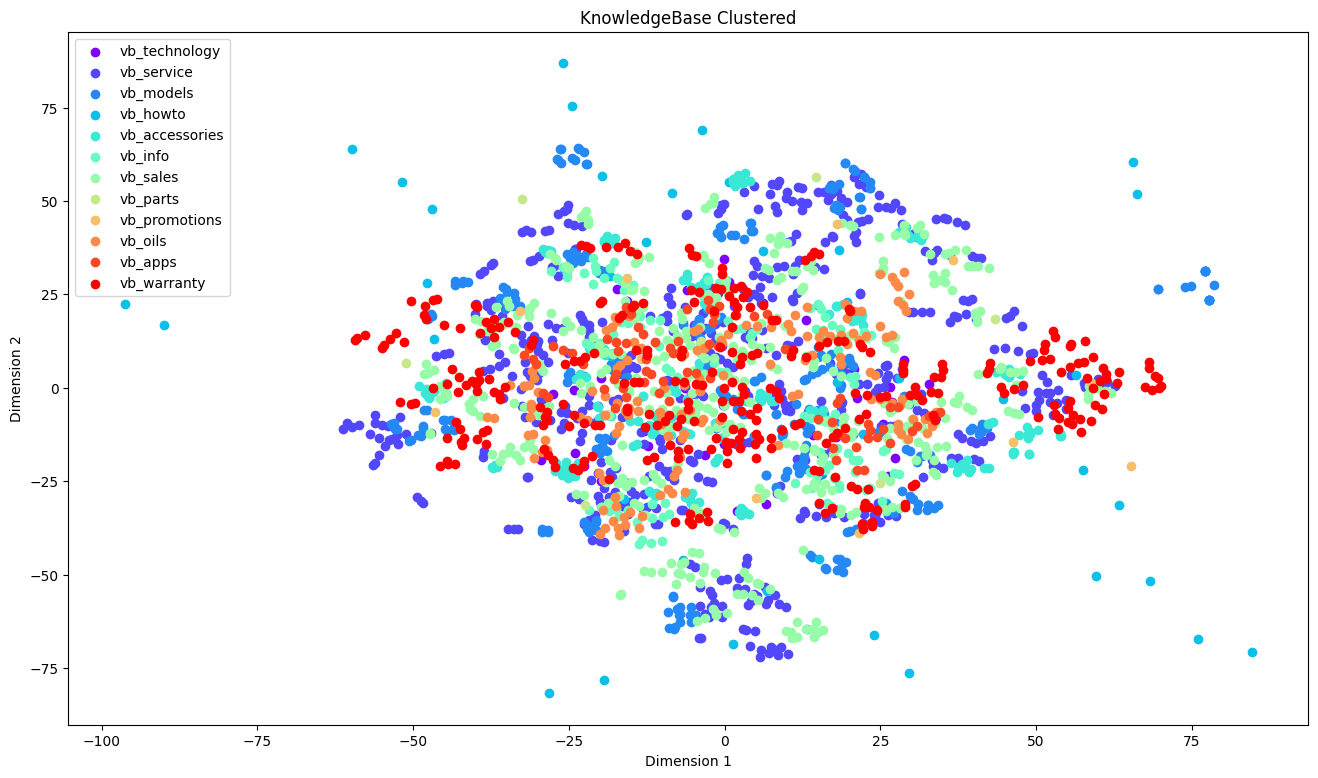